In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM , Dense , GRU, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
import os
directories = [
    "/Users/evangelosgeraridis/Desktop/MEAZON/September 2022",
    "/Users/evangelosgeraridis/Desktop/MEAZON/October 2022"
]

dataframes = {}

for directory in directories:
    files = os.listdir(directory)
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path)
            dataframes[file] = df

In [2]:


fridge_data = pd.concat([dataframes['fridgeS.csv'], dataframes['fridgeO.csv']], ignore_index=True)
aggregated_data = pd.concat([dataframes['AggregatedS.csv'], dataframes['AggregatedO.csv']], ignore_index=True)
dishwasher_data = pd.concat([dataframes['dishwasherS.csv'], dataframes['dishwasherO.csv']], ignore_index=True)
hotplate_data = pd.concat([dataframes['hotplateS.csv'], dataframes['hotplateO.csv']], ignore_index=True)
microwave_data = pd.concat([dataframes['microwaveS.csv'], dataframes['microwaveO.csv']], ignore_index=True)
washing_machine_data = pd.concat([dataframes['washing_machineS.csv'], dataframes['washing_machineO.csv']], ignore_index=True)
water_heater_data = pd.concat([dataframes['water_heaterS.csv'], dataframes['water_heaterO.csv']], ignore_index=True)

data_list = [fridge_data, dishwasher_data, hotplate_data, microwave_data, washing_machine_data, water_heater_data]

for i in range(len(data_list)):
    data_list[i] = aggregated_data.merge(data_list[i], on='ts')
    data_list[i] = data_list[i].set_index('ts')
    data_list[i] = data_list[i].dropna()

fridge_data = pd.DataFrame(data_list[0].rename(columns={'pwrA_x': 'aggregated_active_power', 'apwrA_x': 'aggregated_apparent_power','curA_x': 'aggregated_current','vltA_x': 'aggregated_voltage', 'screA_x': 'aggregated_crest_factor', 'pwrA_y': 'fridge_active_power', 'apwrA_y': 'fridge_apparent_power', 'curA_y': 'fridge_current', 'vltA_y': 'fridge_voltage', 'screA_y': 'fridge_crest_factor'}))
dishwasher_data = pd.DataFrame(data_list[1].rename(columns={'pwrA_x': 'aggregated_active_power', 'apwrA_x': 'aggregated_apparent_power','curA_x': 'aggregated_current','vltA_x': 'aggregated_voltage', 'screA_x': 'aggregated_crest_factor', 'pwrA_y': 'dishwasher_active_power', 'apwrA_y': 'dishwasher_apparent_power', 'curA_y': 'dishwasher_current', 'vltA_y': 'dishwasher_voltage', 'screA_y': 'dishwasher_crest_factor'}))
hotplate_data = pd.DataFrame(data_list[2].rename(columns={'pwrA_x': 'aggregated_active_power', 'apwrA_x': 'aggregated_apparent_power','curA_x': 'aggregated_current','vltA_x': 'aggregated_voltage', 'screA_x': 'aggregated_crest_factor', 'pwrA_y': 'hotplate_active_power', 'apwrA_y': 'hotplate_apparent_power', 'curA_y': 'hotplate_current', 'vltA_y': 'hotplate_voltage', 'screA_y': 'hotplate_crest_factor'}))
microwave_data = pd.DataFrame(data_list[3].rename(columns={'pwrA_x': 'aggregated_active_power', 'apwrA_x': 'aggregated_apparent_power','curA_x': 'aggregated_current','vltA_x': 'aggregated_voltage', 'screA_x': 'aggregated_crest_factor', 'pwrA_y': 'microwave_active_power', 'apwrA_y': 'microwave_apparent_power', 'curA_y': 'microwave_current', 'vltA_y': 'microwave_voltage', 'screA_y': 'microwave_crest_factor'}))
washing_machine_data = pd.DataFrame(data_list[4].rename(columns={'pwrA_x': 'aggregated_active_power', 'apwrA_x': 'aggregated_apparent_power','curA_x': 'aggregated_current','vltA_x': 'aggregated_voltage', 'screA_x': 'aggregated_crest_factor', 'pwrA_y': 'washing_machine_active_power', 'apwrA_y': 'washing_machine_apparent_power', 'curA_y': 'washing_machine_current', 'vltA_y': 'washing_machine_voltage', 'screA_y': 'washing_machine_crest_factor'}))
water_heater_data = pd.DataFrame(data_list[5].rename(columns={'pwrA': 'aggregated_active_power', 'apwrA': 'aggregated_apparent_power','curA': 'aggregated_current','vltA': 'aggregated_voltage', 'screA': 'aggregated_crest_factor', 'pwrC': 'water_heater_active_power', 'apwrC': 'water_heater_apparent_power', 'curC': 'water_heater_current', 'vltC': 'water_heater_voltage', 'screC': 'water_heater_crest_factor'}))


modified_dataframes = [fridge_data, dishwasher_data, hotplate_data, microwave_data, washing_machine_data, water_heater_data]

for df in modified_dataframes:
    print(df)
    print(df.info())


               aggregated_active_power  aggregated_apparent_power   
ts                                                                  
1662048942628                   33.136                     66.092  \
1662059291370                   34.121                     66.943   
1662059293620                   33.852                     67.077   
1662059293670                   33.807                     67.122   
1662059293720                   33.763                     67.077   
...                                ...                        ...   
1665728021166                   34.121                     65.420   
1665728021216                   34.076                     65.555   
1665728021266                   33.897                     65.644   
1665728021316                   33.673                     65.555   
1665766352306                  140.602                    155.514   

               aggregated_current  aggregated_voltage   
ts                                           

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score

# List of appliance-specific datasets
datasets = [washing_machine_data, microwave_data, fridge_data]

# Define the list of target columns for each appliance
target_columns = [
    ['washing_machine_active_power', 'washing_machine_apparent_power', 'washing_machine_current', 'washing_machine_voltage', 'washing_machine_crest_factor'],
    ['microwave_active_power', 'microwave_apparent_power', 'microwave_current', 'microwave_voltage', 'microwave_crest_factor'],
    ['fridge_active_power', 'fridge_apparent_power', 'fridge_current', 'fridge_voltage', 'fridge_crest_factor']
]

train_data = []
test_data = []

# Split each dataset into train and test sets
for dataset in datasets:
    dataset_test_size = int(0.15 * len(dataset))
    dataset_test_indx = len(dataset) - dataset_test_size
    dataset_test = dataset.iloc[dataset_test_indx:].reset_index(drop=True)
    dataset_train = dataset.iloc[:dataset_test_indx].reset_index(drop=True)
    
    train_data.append(dataset_train)
    test_data.append(dataset_test)

washing_machine_train, microwave_train, fridge_train = train_data
washing_machine_test, microwave_test, fridge_test = test_data



In [4]:
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler3 = MinMaxScaler()
fridge_scaled_train = scaler3.fit_transform(fridge_train)
microwave_scaled_train = scaler2.fit_transform(microwave_train)
washing_machine_scaled_train = scaler1.fit_transform(washing_machine_train)
washing_machine_scaled_test = scaler1.transform(washing_machine_test)
fridge_scaled_test = scaler3.transform(fridge_test)
microwave_scaled_test = scaler2.transform(microwave_test)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
    # Convert target columns to a numpy array
aggregated_features = ['aggregated_active_power', 'aggregated_apparent_power', 'aggregated_current', 'aggregated_voltage', 'aggregated_crest_factor']
fridge_features = ['fridge_active_power', 'fridge_apparent_power','fridge_current', 'fridge_voltage', 'fridge_crest_factor']
washing_machine_features = ['washing_machine_active_power', 'washing_machine_apparent_power', 'washing_machine_current','washing_machine_voltage','washing_machine_crest_factor']
microwave_features = ['microwave_active_power', 'microwave_apparent_power', 'microwave_current','microwave_voltage','microwave_crest_factor']
length = 5
batch_size = 1

train_generator_fridge = TimeseriesGenerator(fridge_scaled_train[:, :5], fridge_scaled_train[:, -5:], length=length, batch_size=batch_size)
validation_generator_fridge = TimeseriesGenerator(fridge_scaled_test[:, :5], fridge_scaled_test[:, -5:], length=length, batch_size=batch_size)


# Build the RNN model
model_fridge = Sequential()
model_fridge.add(LSTM(256, activation='relu', input_shape=(length, len(aggregated_features)), return_sequences=True))
model_fridge.add(LSTM(128, return_sequences=True))
model_fridge.add(Dropout(0.25))
model_fridge.add(LSTM(64, return_sequences=True))
model_fridge.add(Dropout(0.25))
model_fridge.add(LSTM(32, return_sequences=True))
model_fridge.add(Dropout(0.25))
model_fridge.add(LSTM(16))
model_fridge.add(Dropout(0.25))
model_fridge.add(Dense(len(fridge_features)))

model_fridge.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'accuracy'])
model_fridge.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=30)

# Train the model
history_fridge = model_fridge.fit(train_generator_fridge, epochs=50, validation_data=validation_generator_fridge, callbacks=[early_stop])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 256)            268288    
                                                                 
 lstm_1 (LSTM)               (None, 5, 128)            197120    
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 5, 32)             12416     
                                                                 
 dropout_2 (Dropout)         (None, 5, 32)             0

2023-06-01 15:44:06.931772: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


614/614 [==============================] - 11s 11ms/step - loss: 0.0574 - mse: 0.0574 - mae: 0.1779 - accuracy: 0.6840 - val_loss: 0.0315 - val_mse: 0.0315 - val_mae: 0.1285 - val_accuracy: 0.9135
Epoch 2/50
614/614 [==============================] - 6s 10ms/step - loss: 0.0493 - mse: 0.0493 - mae: 0.1649 - accuracy: 0.7182 - val_loss: 0.0352 - val_mse: 0.0352 - val_mae: 0.1457 - val_accuracy: 0.9135
Epoch 3/50
614/614 [==============================] - 6s 10ms/step - loss: 0.0465 - mse: 0.0465 - mae: 0.1567 - accuracy: 0.7166 - val_loss: 0.0282 - val_mse: 0.0282 - val_mae: 0.0938 - val_accuracy: 0.9135
Epoch 4/50
614/614 [==============================] - 7s 12ms/step - loss: 0.0437 - mse: 0.0437 - mae: 0.1482 - accuracy: 0.7166 - val_loss: 0.0357 - val_mse: 0.0357 - val_mae: 0.1448 - val_accuracy: 0.9135
Epoch 5/50
614/614 [==============================] - 6s 10ms/step - loss: 0.0402 - mse: 0.0402 - mae: 0.1432 - accuracy: 0.7313 - val_loss: 0.0291 - val_mse: 0.0291 - val_mae: 0.117

In [36]:
n_features_f = len(aggregated_features)  # Number of aggregated features

test_predictions_f = []


first_eval_batch_f = fridge_scaled_train[-length:, :5]   # Select the aggregated features
# to be exact the last 5 from the scaled (from the columns we use to predict , the aggregated oned
# which are the first five cols) and then from these cols we get the last 5 because we set the 
#  length to be 5 and these will be used to predict the first values we want one point in to the future
# hence the last 5 are used to predict the first and then we loop
# to go through all our test dataset 109 lines

first_eval_batch_f = first_eval_batch_f.reshape((1, length, n_features_f))

current_batch_f = first_eval_batch_f

for i in range(len(fridge_test)):        #
    # Get prediction 1 time step ahead ([0] is for grabbing just the number instead of [array])
    current_pred_f = model_fridge.predict(current_batch_f)[0]

    # Inverse transform the predicted values

    # Store the actual prediction
    test_predictions_f.append(current_pred_f)

    # Update the batch to include the prediction and drop the first value
    current_batch_f = np.append(current_batch_f[:, 1:, :], [[current_pred_f]], axis=1)

1/1 [==============================] - 0s 17ms/step


In [37]:
test_predictions_f = pd.DataFrame(test_predictions_f)
test_predictions_f.columns = ['predicted_fridge_active_power','predicted_fridge_apparent_power','predicted_fridge_current', 'predicted_fridge_voltage', 'predicted_fridge_crest_factor']
print(test_predictions_f.info())
# since we transformed all the 10 collumns (with minmaxscaler), but we used 5 of them to predict 5
# 5 aggregated used to predict the 5 fridges data, we cannot inverse transform.
# however now we will create a dataframe with 109 entries and 5 columns(because the predictions
# of the actual test values dimensions are 109 * 5 ) this dataset will be filled with zeros,
# since the columns that have 0 will have across all their entries the same values
# after the inverse transform and then we will remove those columns 

filler_df = pd.DataFrame(0, index=range(109), columns=range(5))
preds_f = pd.concat([test_predictions_f, filler_df], axis=1)
preds_f

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   predicted_fridge_active_power    109 non-null    float32
 1   predicted_fridge_apparent_power  109 non-null    float32
 2   predicted_fridge_current         109 non-null    float32
 3   predicted_fridge_voltage         109 non-null    float32
 4   predicted_fridge_crest_factor    109 non-null    float32
dtypes: float32(5)
memory usage: 2.3 KB
None


,predicted_fridge_active_power,predicted_fridge_apparent_power,predicted_fridge_current,predicted_fridge_voltage,predicted_fridge_crest_factor,0,1,2,3,4
0,0.057591,0.063414,0.062409,0.593714,0.302341,0,0,0,0,0
1,-0.000130,0.007819,0.006945,0.659506,0.302708,0,0,0,0,0
2,0.009386,0.018373,0.017873,0.614600,0.303660,0,0,0,0,0
3,0.083385,0.100815,0.100277,0.460178,0.314797,0,0,0,0,0
4,0.577714,0.609522,0.607050,0.262659,0.340964,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
104,0.056162,0.063379,0.065218,0.405374,0.307960,0,0,0,0,0
105,0.040049,0.052799,0.054405,0.388722,0.312600,0,0,0,0,0
106,0.056162,0.063378,0.065218,0.405374,0.307960,0,0,0,0,0
107,0.040049,0.052799,0.054405,0.388722,0.312600,0,0,0,0,0


In [38]:

inverse_transformed_data = scaler3.inverse_transform(preds_f)
true_predictions_fridge = pd.DataFrame(inverse_transformed_data)
true_predictions_fridge 

,0,1,2,3,4,5,6,7,8,9
0,245.502129,296.725827,1.349821,222.621984,3.212827,13.889,14.058,0.065,216.281,0.072
1,30.548548,91.154328,0.401715,223.335957,3.215887,13.889,14.058,0.065,216.281,0.072
2,65.986691,130.179256,0.588519,222.848644,3.223828,13.889,14.058,0.065,216.281,0.072
3,341.559208,435.027105,1.997141,221.172852,3.316722,13.889,14.058,0.065,216.281,0.072
4,2182.460831,2316.076928,10.659905,219.029377,3.534978,13.889,14.058,0.065,216.281,0.072
...,...,...,...,...,...,...,...,...,...,...
104,240.181144,296.597085,1.397835,220.578118,3.259691,13.889,14.058,0.065,216.281,0.072
105,180.173792,257.475511,1.212998,220.397407,3.298401,13.889,14.058,0.065,216.281,0.072
106,240.180451,296.596369,1.397831,220.578118,3.259691,13.889,14.058,0.065,216.281,0.072
107,180.173348,257.475071,1.212996,220.397407,3.298400,13.889,14.058,0.065,216.281,0.072


In [39]:
# we see that columns 5,6,7,8 and 9 contain the equal values across all the entries, so
# we drop them
true_predictions_fridge = true_predictions_fridge.iloc[:, :5]
true_predictions_fridge.columns = ['predicted_fridge_active_power','predicted_fridge_apparent_power','predicted_fridge_current', 'predicted_fridge_voltage', 'predicted_fridge_crest_factor']
true_predictions_fridge

,predicted_fridge_active_power,predicted_fridge_apparent_power,predicted_fridge_current,predicted_fridge_voltage,predicted_fridge_crest_factor
0,245.502129,296.725827,1.349821,222.621984,3.212827
1,30.548548,91.154328,0.401715,223.335957,3.215887
2,65.986691,130.179256,0.588519,222.848644,3.223828
3,341.559208,435.027105,1.997141,221.172852,3.316722
4,2182.460831,2316.076928,10.659905,219.029377,3.534978
...,...,...,...,...,...
104,240.181144,296.597085,1.397835,220.578118,3.259691
105,180.173792,257.475511,1.212998,220.397407,3.298401
106,240.180451,296.596369,1.397831,220.578118,3.259691
107,180.173348,257.475071,1.212996,220.397407,3.298400


In [40]:

fridge_test = fridge_test.iloc[:, -5:]
fridge_test

,fridge_active_power,fridge_apparent_power,fridge_current,fridge_voltage,fridge_crest_factor
0,346.769,360.155,1.616,223.831,0.618
1,254.184,292.649,1.311,223.853,0.733
2,213.357,265.950,1.190,223.924,0.757
3,193.341,252.659,1.130,223.995,0.783
4,182.632,244.398,1.093,224.012,0.785
...,...,...,...,...,...
104,14.923,15.017,0.068,220.632,0.714
105,14.785,14.858,0.067,220.655,0.704
106,14.699,14.799,0.067,220.684,0.714
107,14.738,14.872,0.068,220.717,0.711


In [41]:
metrics_fridge = pd.DataFrame(history_fridge.history)
metrics_fridge
losses_fridge = metrics_fridge[['loss','val_loss']]
mae_fridge = metrics_fridge[['mae','val_mae']]
accuracy_fridge = metrics_fridge[['accuracy' , 'val_accuracy']]

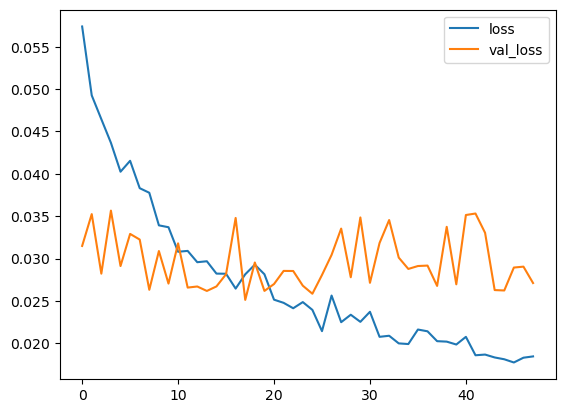

In [42]:
losses_fridge.plot()

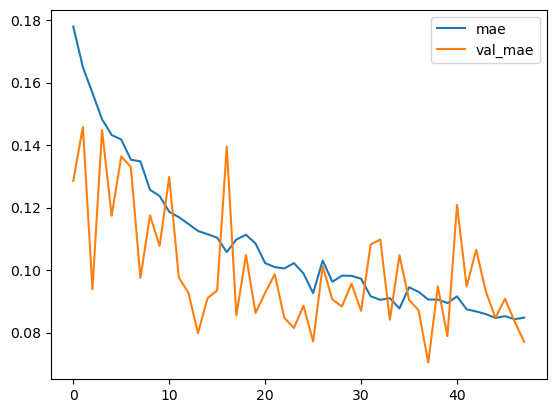

In [43]:
mae_fridge.plot()

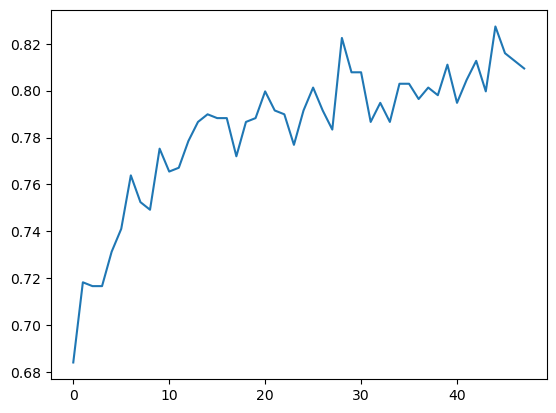

In [44]:
accuracy_fridge['accuracy'].plot()

/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


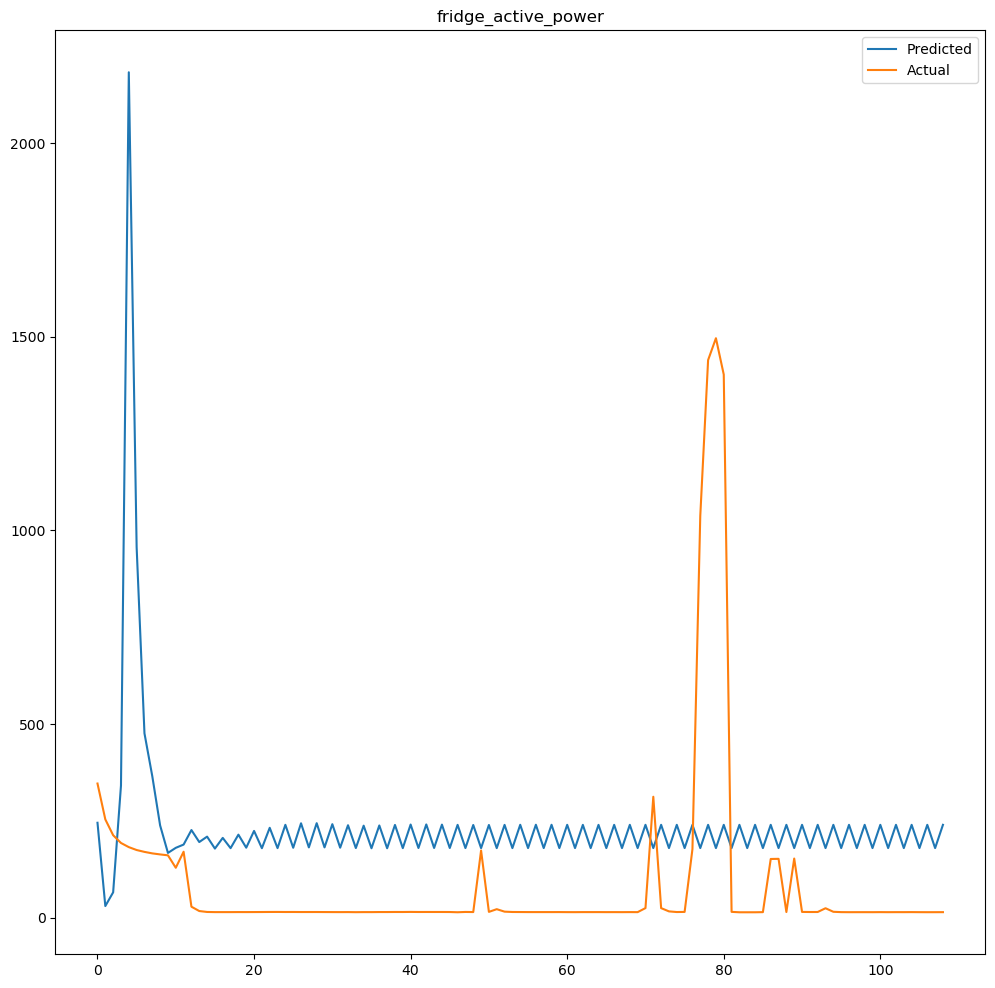

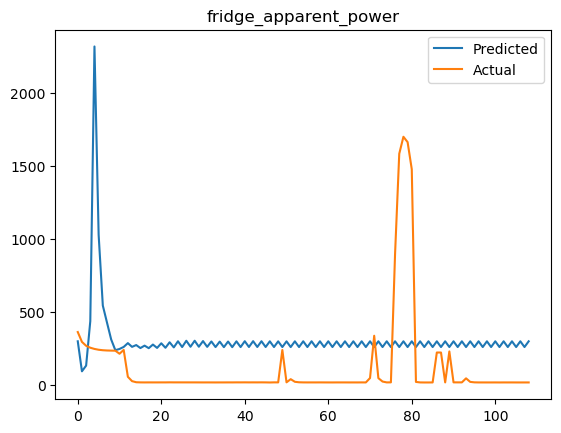

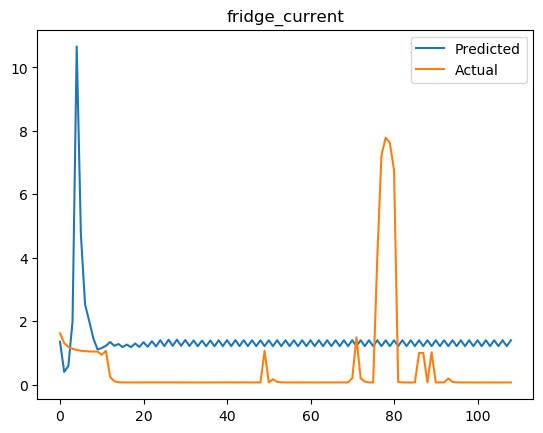

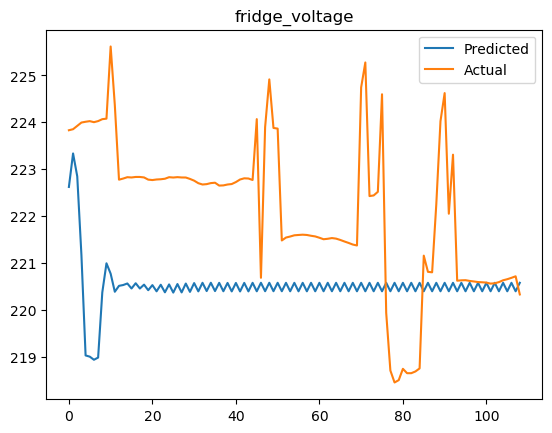

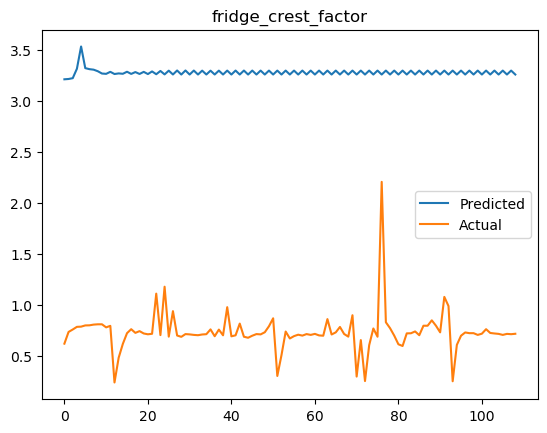

In [45]:
plt.figure(figsize=(12,12))
i = 0
for feature in fridge_test.columns:
    plt.plot(true_predictions_fridge.index, true_predictions_fridge[true_predictions_fridge.columns[i]], label='Predicted')
    plt.plot(fridge_test.index, fridge_test[fridge_test.columns[i]], label='Actual')
    plt.title(fridge_test.columns[i])
    plt.legend()
    plt.show()
    i = i+1

In [27]:
model_washing_machine = Sequential()
model_washing_machine.add(LSTM(256, activation='relu', input_shape=(length, len(aggregated_features)), return_sequences=True))
model_washing_machine.add(LSTM(128, return_sequences=True))
model_washing_machine.add(Dropout(0.25))
model_washing_machine.add(LSTM(64, return_sequences=True))
model_washing_machine.add(Dropout(0.25))
model_washing_machine.add(LSTM(32, return_sequences=True))
model_washing_machine.add(Dropout(0.25))
model_washing_machine.add(LSTM(16))
model_washing_machine.add(Dropout(0.25))
model_washing_machine.add(Dense(len(washing_machine_features)))

model_washing_machine.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'accuracy'])
model_washing_machine.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=30)
train_generator_washing_machine = TimeseriesGenerator(washing_machine_scaled_train[:, :5], washing_machine_scaled_train[:, -5:], length=length, batch_size=batch_size)
validation_generator_washing_machine = TimeseriesGenerator(washing_machine_scaled_test[:, :5], washing_machine_scaled_test[:, -5:], length=length, batch_size=batch_size)


# Train the model

history_washing_machine = model_washing_machine.fit(train_generator_washing_machine, epochs=50, validation_data=validation_generator_washing_machine, callbacks=[early_stop])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 5, 256)            268288    
                                                                 
 lstm_6 (LSTM)               (None, 5, 128)            197120    
                                                                 
 dropout_4 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_7 (LSTM)               (None, 5, 64)             49408     
                                                                 
 dropout_5 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_8 (LSTM)               (None, 5, 32)             12416     
                                                                 
 dropout_6 (Dropout)         (None, 5, 32)            

In [46]:
metrics_washing_machine = pd.DataFrame(history_washing_machine.history)
print(metrics_washing_machine)
losses_washing_machine = metrics_washing_machine[['loss','val_loss']]
mae_washing_machine = metrics_washing_machine[['mae','val_mae']]
accuracy_washing_machine = metrics_washing_machine[['accuracy' , 'val_accuracy']]

        loss       mse       mae  accuracy  val_loss   val_mse   val_mae  \
0   0.059742  0.059742  0.165453  0.677632  0.025140  0.025140  0.096487   
1   0.037404  0.037404  0.127228  0.669408  0.024496  0.024496  0.069376   
2   0.037134  0.037134  0.123282  0.667763  0.017215  0.017215  0.093291   
3   0.030093  0.030093  0.110195  0.700658  0.014708  0.014708  0.076349   
4   0.024362  0.024362  0.098847  0.735197  0.014622  0.014622  0.089235   
5   0.021587  0.021587  0.092300  0.722039  0.011834  0.011834  0.073330   
6   0.019900  0.019900  0.089355  0.713816  0.009375  0.009375  0.047267   
7   0.021507  0.021507  0.090865  0.730263  0.009352  0.009352  0.056393   
8   0.017623  0.017623  0.084608  0.748355  0.010153  0.010153  0.059353   
9   0.018339  0.018339  0.083849  0.725329  0.009897  0.009897  0.052762   
10  0.017654  0.017654  0.084260  0.751645  0.009438  0.009438  0.060396   
11  0.018310  0.018310  0.083435  0.751645  0.008587  0.008587  0.060064   
12  0.022443

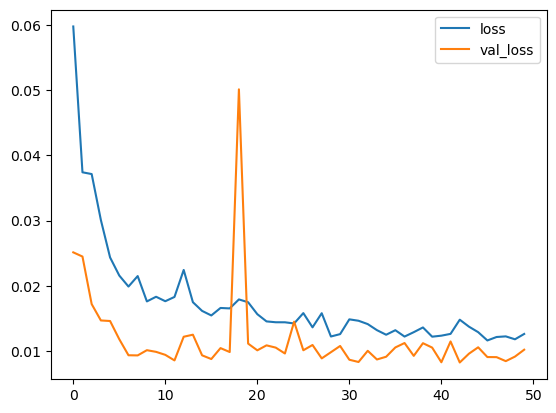

In [47]:
losses_washing_machine.plot()

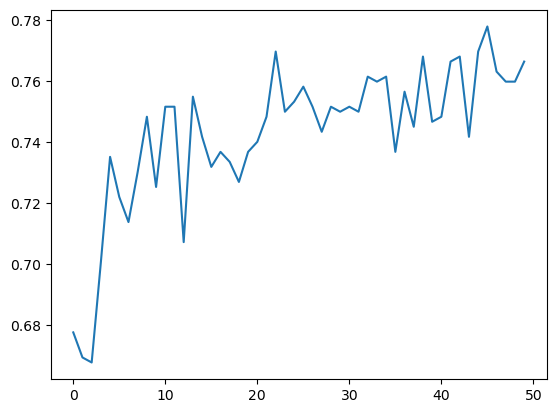

In [48]:
accuracy_washing_machine['accuracy'].plot()

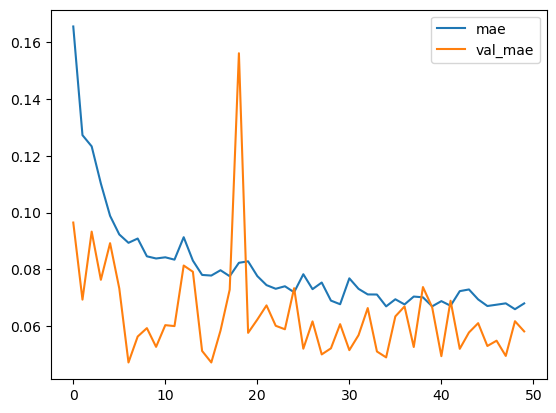

In [49]:
mae_washing_machine.plot()

In [50]:
n_features_w = len(aggregated_features)  # Number of aggregated features

test_predictions_w = []


first_eval_batch_w = washing_machine_scaled_train[-length:, :5] 
first_eval_batch_w = first_eval_batch_w.reshape((1, length, n_features_w))


current_batch_w = first_eval_batch_w

for i in range(len(washing_machine_test)):        #
    # Get prediction 1 time step ahead ([0] is for grabbing just the number instead of [array])
    current_pred_w = model_washing_machine.predict(current_batch_w)[0]

    # Inverse transform the predicted values

    # Store the actual prediction
    test_predictions_w.append(current_pred_w)

    # Update the batch to include the prediction and drop the first value
    current_batch_w = np.append(current_batch_w[:, 1:, :], [[current_pred_w]], axis=1)


1/1 [==============================] - 0s 14ms/step


In [23]:
# we need dimensions of wash mach test to create the filler to match it
washing_machine_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   aggregated_active_power         108 non-null    float64
 1   aggregated_apparent_power       108 non-null    float64
 2   aggregated_current              108 non-null    float64
 3   aggregated_voltage              108 non-null    float64
 4   aggregated_crest_factor         108 non-null    float64
 5   washing_machine_active_power    108 non-null    float64
 6   washing_machine_apparent_power  108 non-null    float64
 7   washing_machine_current         108 non-null    float64
 8   washing_machine_voltage         108 non-null    float64
 9   washing_machine_crest_factor    108 non-null    float64
dtypes: float64(10)
memory usage: 8.6 KB


In [51]:
test_predictions_w = pd.DataFrame(test_predictions_w)
test_predictions_w.columns = ['predicted_washing_machine_active_power','predicted_washing_machine_apparent_power','predicted_washing_machine_current', 'predicted_washing_machine_voltage', 'predicted_washing_machine_crest_factor']
print(test_predictions_w.info())
# since we transformed all the 10 collumns (with minmaxscaler), but we used 5 of them to predict 5
# 5 aggregated used to predict the 5 fridges data, we cannot inverse transform.
# however now we will create a dataframe with 109 entries and 5 columns(because the predictions
# of the actual test values dimensions are 109 * 5 ) this dataset will be filled with zeros,
# since the columns that have 0 will have across all their entries the same values
# after the inverse transform and then we will remove those columns 

filler_df = pd.DataFrame(0, index=range(108), columns=range(5))
preds_w = pd.concat([test_predictions_w, filler_df], axis=1)
preds_w

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 5 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   predicted_washing_machine_active_power    108 non-null    float32
 1   predicted_washing_machine_apparent_power  108 non-null    float32
 2   predicted_washing_machine_current         108 non-null    float32
 3   predicted_washing_machine_voltage         108 non-null    float32
 4   predicted_washing_machine_crest_factor    108 non-null    float32
dtypes: float32(5)
memory usage: 2.2 KB
None


,predicted_washing_machine_active_power,predicted_washing_machine_apparent_power,predicted_washing_machine_current,predicted_washing_machine_voltage,predicted_washing_machine_crest_factor,0,1,2,3,4
0,0.880495,0.883415,0.885330,0.412579,0.311703,0,0,0,0,0
1,0.878839,0.881735,0.883567,0.421478,0.312429,0,0,0,0,0
2,0.871349,0.874331,0.875947,0.443399,0.314222,0,0,0,0,0
3,0.866887,0.869890,0.871325,0.461899,0.316182,0,0,0,0,0
4,0.863858,0.866634,0.867816,0.494453,0.320026,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
103,0.862665,0.865398,0.866434,0.511383,0.322115,0,0,0,0,0
104,0.862665,0.865398,0.866434,0.511382,0.322115,0,0,0,0,0
105,0.862665,0.865398,0.866434,0.511383,0.322115,0,0,0,0,0
106,0.862665,0.865398,0.866434,0.511382,0.322115,0,0,0,0,0


In [52]:
inverse_transformed_data = scaler1.inverse_transform(preds_w)
true_predictions_washing_machine = pd.DataFrame(inverse_transformed_data)
true_predictions_washing_machine

,0,1,2,3,4,5,6,7,8,9
0,3375.683332,3395.561210,15.449337,221.700149,1.871491,0.0,0.0,0.0,213.561,0.021
1,3369.472454,3389.291037,15.419453,221.821375,1.873946,0.0,0.0,0.0,213.561,0.021
2,3341.363700,3361.644949,15.290304,222.119976,1.880013,0.0,0.0,0.0,213.561,0.021
3,3324.621462,3345.066464,15.211967,222.371986,1.886642,0.0,0.0,0.0,213.561,0.021
4,3313.254946,3332.909547,15.152482,222.815436,1.899646,0.0,0.0,0.0,213.561,0.021
...,...,...,...,...,...,...,...,...,...,...
103,3308.779241,3328.294373,15.129060,223.046053,1.906714,0.0,0.0,0.0,213.561,0.021
104,3308.779464,3328.294596,15.129060,223.046052,1.906714,0.0,0.0,0.0,213.561,0.021
105,3308.779464,3328.294596,15.129060,223.046053,1.906714,0.0,0.0,0.0,213.561,0.021
106,3308.779464,3328.294596,15.129060,223.046052,1.906714,0.0,0.0,0.0,213.561,0.021


In [53]:
# we see that columns 5,6,7,8 and 9 contain the equal values across all the entries, so
# we drop them
true_predictions_washing_machine = true_predictions_washing_machine.iloc[:, :5]
true_predictions_washing_machine.columns = ['predicted_washing_machine_active_power','predicted_washing_machine_apparent_power','predicted_washing_machine_current', 'predicted_washing_machine_voltage', 'predicted_washing_machine_crest_factor']
true_predictions_washing_machine

,predicted_washing_machine_active_power,predicted_washing_machine_apparent_power,predicted_washing_machine_current,predicted_washing_machine_voltage,predicted_washing_machine_crest_factor
0,3375.683332,3395.561210,15.449337,221.700149,1.871491
1,3369.472454,3389.291037,15.419453,221.821375,1.873946
2,3341.363700,3361.644949,15.290304,222.119976,1.880013
3,3324.621462,3345.066464,15.211967,222.371986,1.886642
4,3313.254946,3332.909547,15.152482,222.815436,1.899646
...,...,...,...,...,...
103,3308.779241,3328.294373,15.129060,223.046053,1.906714
104,3308.779464,3328.294596,15.129060,223.046052,1.906714
105,3308.779464,3328.294596,15.129060,223.046053,1.906714
106,3308.779464,3328.294596,15.129060,223.046052,1.906714


In [54]:
washing_machine_test = washing_machine_test.iloc[:, -5:]
washing_machine_test

,washing_machine_active_power,washing_machine_apparent_power,washing_machine_current,washing_machine_voltage,washing_machine_crest_factor
0,1961.430,1962.202,9.064,216.916,0.679
1,1957.583,1959.726,9.050,216.961,0.682
2,1956.332,1959.197,9.046,217.011,0.681
3,1956.570,1960.224,9.050,217.029,0.682
4,1960.979,1966.443,9.080,216.991,0.682
...,...,...,...,...,...
103,191.761,214.650,0.965,222.733,0.716
104,145.874,157.114,0.714,220.575,0.658
105,132.481,139.571,0.634,220.574,0.656
106,99.223,104.632,0.474,221.175,0.678


/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


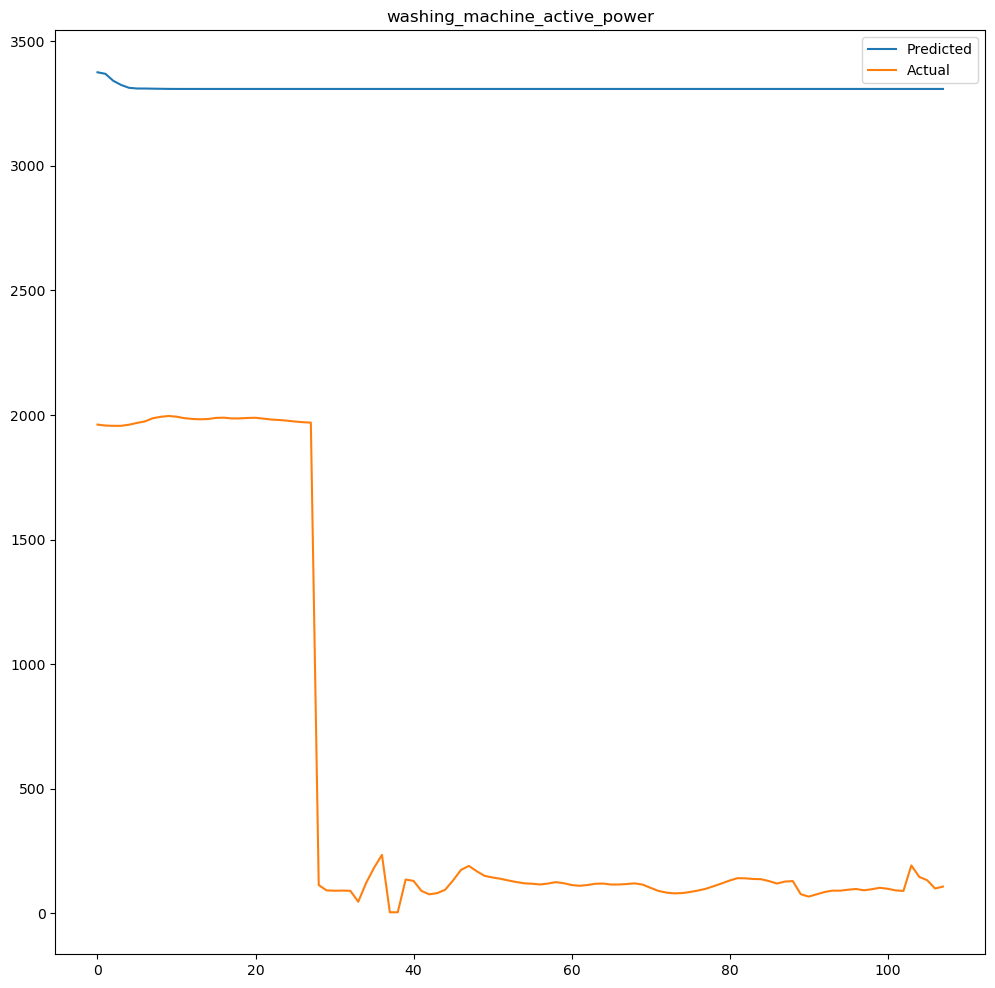

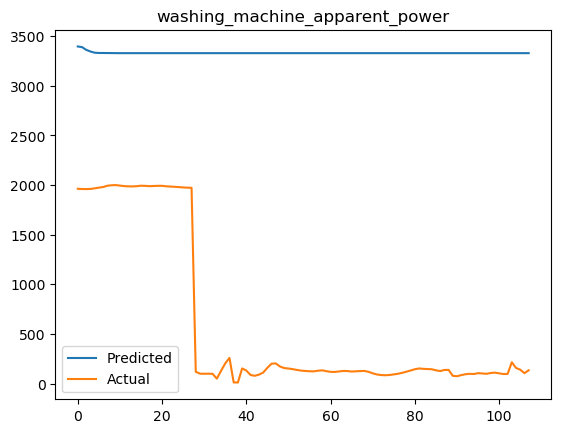

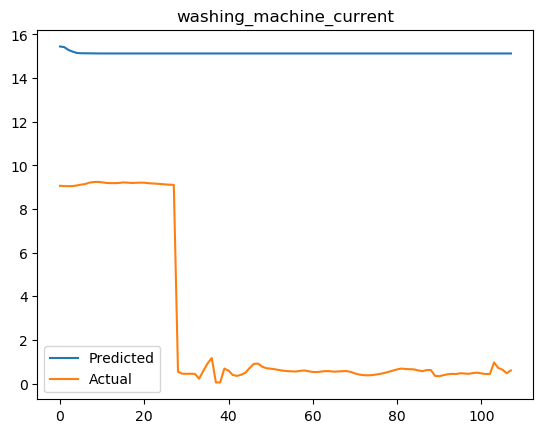

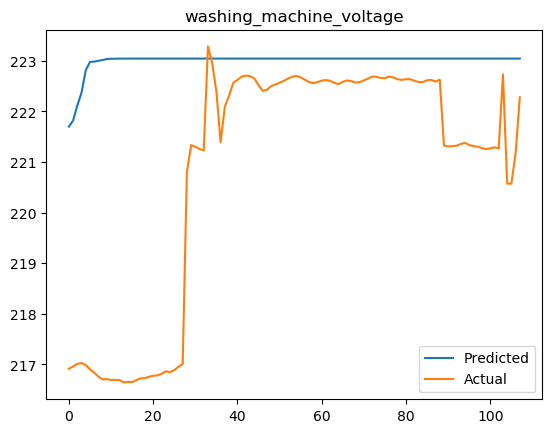

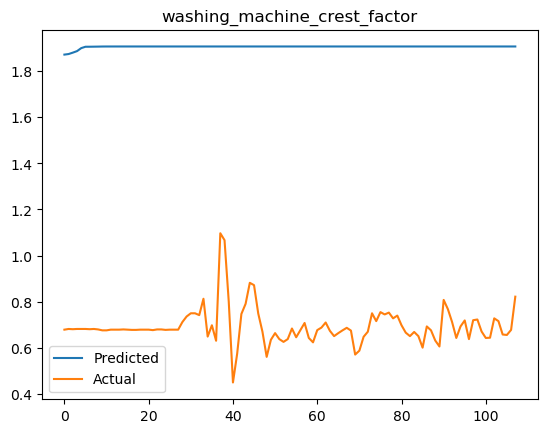

In [55]:
plt.figure(figsize=(12,12))
i = 0
for feature in washing_machine_test.columns:
    plt.plot(true_predictions_washing_machine.index, true_predictions_washing_machine[true_predictions_washing_machine.columns[i]], label='Predicted')
    plt.plot(washing_machine_test.index, washing_machine_test[washing_machine_test.columns[i]], label='Actual')
    plt.title(washing_machine_test.columns[i])
    plt.legend()
    plt.show()
    i = i + 1

In [56]:
model_microwave = Sequential()
model_microwave.add(LSTM(256, activation='relu', input_shape=(length, len(aggregated_features)), return_sequences=True))
model_microwave.add(LSTM(128, return_sequences=True))
model_microwave.add(Dropout(0.25))
model_microwave.add(LSTM(64, return_sequences=True))
model_microwave.add(Dropout(0.25))
model_microwave.add(LSTM(32, return_sequences=True))
model_microwave.add(Dropout(0.25))
model_microwave.add(LSTM(16))
model_microwave.add(Dropout(0.25))
model_microwave.add(Dense(len(microwave_features)))

model_microwave.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'accuracy'])
model_microwave.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=30)
train_generator_microwave = TimeseriesGenerator(microwave_scaled_train[:, :5], microwave_scaled_train[:, -5:], length=length, batch_size=batch_size)
validation_generator_microwave = TimeseriesGenerator(microwave_scaled_test[:, :5], microwave_scaled_test[:, -5:], length=length, batch_size=batch_size)


# Train the model

history_microwave = model_microwave.fit(train_generator_microwave, epochs=50, validation_data=validation_generator_microwave, callbacks=[early_stop])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 5, 256)            268288    
                                                                 
 lstm_11 (LSTM)              (None, 5, 128)            197120    
                                                                 
 dropout_8 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_12 (LSTM)              (None, 5, 64)             49408     
                                                                 
 dropout_9 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_13 (LSTM)              (None, 5, 32)             12416     
                                                                 
 dropout_10 (Dropout)        (None, 5, 32)            

In [57]:
metrics_microwave = pd.DataFrame(history_microwave.history)
print(metrics_microwave)
losses_microwave = metrics_microwave[['loss','val_loss']]
mae_microwave = metrics_microwave[['mae','val_mae']]
accuracy_microwave = metrics_microwave[['accuracy' , 'val_accuracy']]

        loss       mse       mae  accuracy  val_loss   val_mse   val_mae  \
0   0.108970  0.108970  0.254481  0.343915  0.058979  0.058979  0.204584   
1   0.080283  0.080283  0.214775  0.446208  0.038591  0.038591  0.161362   
2   0.072408  0.072408  0.199810  0.472663  0.041023  0.041023  0.166415   
3   0.063461  0.063461  0.183220  0.507937  0.033346  0.033346  0.134561   
4   0.061204  0.061204  0.180021  0.536155  0.033333  0.033333  0.136050   
5   0.057182  0.057182  0.172764  0.536155  0.033633  0.033633  0.138295   
6   0.054435  0.054435  0.166420  0.557319  0.027972  0.027972  0.125898   
7   0.054769  0.054769  0.164173  0.523810  0.045282  0.045282  0.160770   
8   0.048814  0.048814  0.154847  0.539683  0.024783  0.024783  0.115152   
9   0.050686  0.050686  0.154418  0.566138  0.054571  0.054571  0.167921   
10  0.047315  0.047315  0.150181  0.574956  0.029957  0.029957  0.129944   
11  0.048185  0.048185  0.151601  0.567901  0.069172  0.069172  0.177875   
12  0.048457

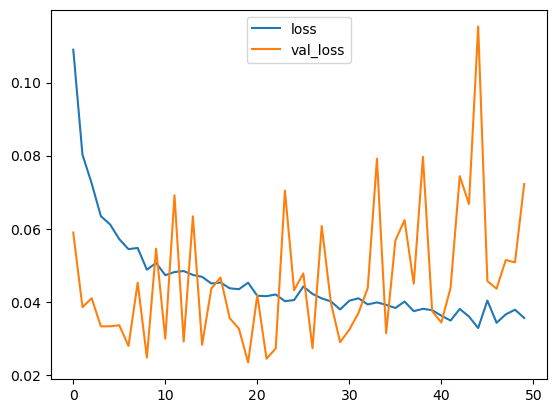

In [58]:
losses_microwave.plot()

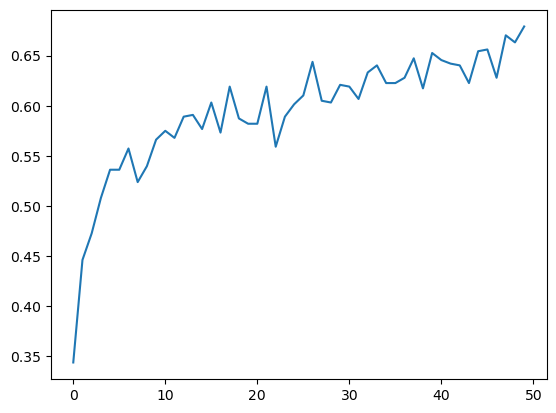

In [59]:
accuracy_microwave['accuracy'].plot()

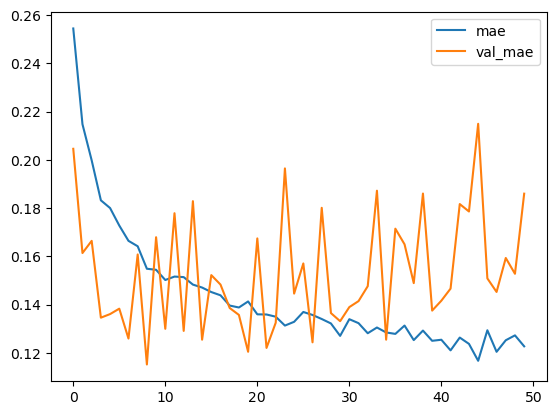

In [60]:
mae_microwave.plot()

In [77]:
n_features_m = len(aggregated_features)  # Number of aggregated features

test_predictions_m = []

first_eval_batch_m = microwave_scaled_train[-length:, :5] 
first_eval_batch_m = first_eval_batch_m.reshape((1, length, n_features_m))
current_batch_m = first_eval_batch_m

for i in range(len(microwave_test)):        #
    # Get prediction 1 time step ahead ([0] is for grabbing just the number instead of [array])
    current_pred_m = model_microwave.predict(current_batch_m)[0]

    # Inverse transform the predicted values

    # Store the actual prediction
    test_predictions_m.append(current_pred_m)

    # Update the batch to include the prediction and drop the first value
    current_batch_m = np.append(current_batch_m[:, 1:, :], [[current_pred_m]], axis=1)



1/1 [==============================] - 0s 16ms/step


In [62]:
microwave_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   aggregated_active_power    100 non-null    float64
 1   aggregated_apparent_power  100 non-null    float64
 2   aggregated_current         100 non-null    float64
 3   aggregated_voltage         100 non-null    float64
 4   aggregated_crest_factor    100 non-null    float64
 5   microwave_active_power     100 non-null    float64
 6   microwave_apparent_power   100 non-null    float64
 7   microwave_current          100 non-null    float64
 8   microwave_voltage          100 non-null    float64
 9   microwave_crest_factor     100 non-null    float64
dtypes: float64(10)
memory usage: 7.9 KB


In [78]:
test_predictions_m = pd.DataFrame(test_predictions_m)
test_predictions_m.columns = ['predicted_microwave_active_power','predicted_microwave_apparent_power','predicted_microwave_current', 'predicted_microwave_voltage', 'predicted_microwave_crest_factor']
print(test_predictions_m.info())
# since we transformed all the 10 collumns (with minmaxscaler), but we used 5 of them to predict 5
# 5 aggregated used to predict the 5 fridges data, we cannot inverse transform.
# however now we will create a dataframe with 109 entries and 5 columns(because the predictions
# of the actual test values dimensions are 109 * 5 ) this dataset will be filled with zeros,
# since the columns that have 0 will have across all their entries the same values
# after the inverse transform and then we will remove those columns 

filler_df = pd.DataFrame(0, index=range(100), columns=range(5))
preds_m = pd.concat([test_predictions_m, filler_df], axis=1)
preds_m

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   predicted_microwave_active_power    100 non-null    float32
 1   predicted_microwave_apparent_power  100 non-null    float32
 2   predicted_microwave_current         100 non-null    float32
 3   predicted_microwave_voltage         100 non-null    float32
 4   predicted_microwave_crest_factor    100 non-null    float32
dtypes: float32(5)
memory usage: 2.1 KB
None


,predicted_microwave_active_power,predicted_microwave_apparent_power,predicted_microwave_current,predicted_microwave_voltage,predicted_microwave_crest_factor,0,1,2,3,4
0,0.111513,0.128928,0.131353,0.610030,0.480587,0,0,0,0,0
1,0.461440,0.415617,0.426132,0.281298,0.366883,0,0,0,0,0
2,0.812858,0.748752,0.768775,0.131941,0.362258,0,0,0,0,0
3,0.917320,0.875406,0.893037,0.163235,0.403311,0,0,0,0,0
4,0.847326,0.848781,0.863820,0.274134,0.470859,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
95,0.874375,0.879924,0.899967,0.249136,0.477304,0,0,0,0,0
96,0.874375,0.879924,0.899967,0.249136,0.477304,0,0,0,0,0
97,0.874375,0.879924,0.899967,0.249136,0.477304,0,0,0,0,0
98,0.874375,0.879924,0.899967,0.249136,0.477304,0,0,0,0,0


In [79]:
inverse_transformed_data = scaler2.inverse_transform(preds_m)
true_predictions_microwave = pd.DataFrame(inverse_transformed_data)
true_predictions_microwave

,0,1,2,3,4,5,6,7,8,9
0,633.296013,715.198379,3.246986,222.617716,1.717538,0.04,2.542,0.012,214.875,0.033
1,1839.743519,1699.065105,7.834033,219.100612,1.489334,0.04,2.542,0.012,214.875,0.033
2,3051.334071,2842.325309,13.165906,217.502634,1.480052,0.04,2.542,0.012,214.875,0.033
3,3411.491325,3276.978729,15.099546,217.837456,1.562446,0.04,2.542,0.012,214.875,0.033
4,3170.171779,3185.606394,14.644897,219.023958,1.698014,0.04,2.542,0.012,214.875,0.033
...,...,...,...,...,...,...,...,...,...,...
95,3263.428450,3292.483393,15.207388,218.756504,1.710950,0.04,2.542,0.012,214.875,0.033
96,3263.428450,3292.483598,15.207388,218.756504,1.710950,0.04,2.542,0.012,214.875,0.033
97,3263.428450,3292.483598,15.207388,218.756504,1.710950,0.04,2.542,0.012,214.875,0.033
98,3263.428450,3292.483598,15.207389,218.756504,1.710950,0.04,2.542,0.012,214.875,0.033


In [80]:
# we see that columns 5,6,7,8 and 9 contain the equal values across all the entries, so
# we drop them
true_predictions_microwave = true_predictions_microwave.iloc[:, :5]
true_predictions_microwave.columns = ['predicted_microwave_active_power','predicted_microwave_apparent_power','predicted_microwave_current', 'predicted_microwave_voltage', 'predicted_microwave_crest_factor']
true_predictions_microwave

,predicted_microwave_active_power,predicted_microwave_apparent_power,predicted_microwave_current,predicted_microwave_voltage,predicted_microwave_crest_factor
0,633.296013,715.198379,3.246986,222.617716,1.717538
1,1839.743519,1699.065105,7.834033,219.100612,1.489334
2,3051.334071,2842.325309,13.165906,217.502634,1.480052
3,3411.491325,3276.978729,15.099546,217.837456,1.562446
4,3170.171779,3185.606394,14.644897,219.023958,1.698014
...,...,...,...,...,...
95,3263.428450,3292.483393,15.207388,218.756504,1.710950
96,3263.428450,3292.483598,15.207388,218.756504,1.710950
97,3263.428450,3292.483598,15.207388,218.756504,1.710950
98,3263.428450,3292.483598,15.207389,218.756504,1.710950


/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/miniconda3/envs/nilmenv/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


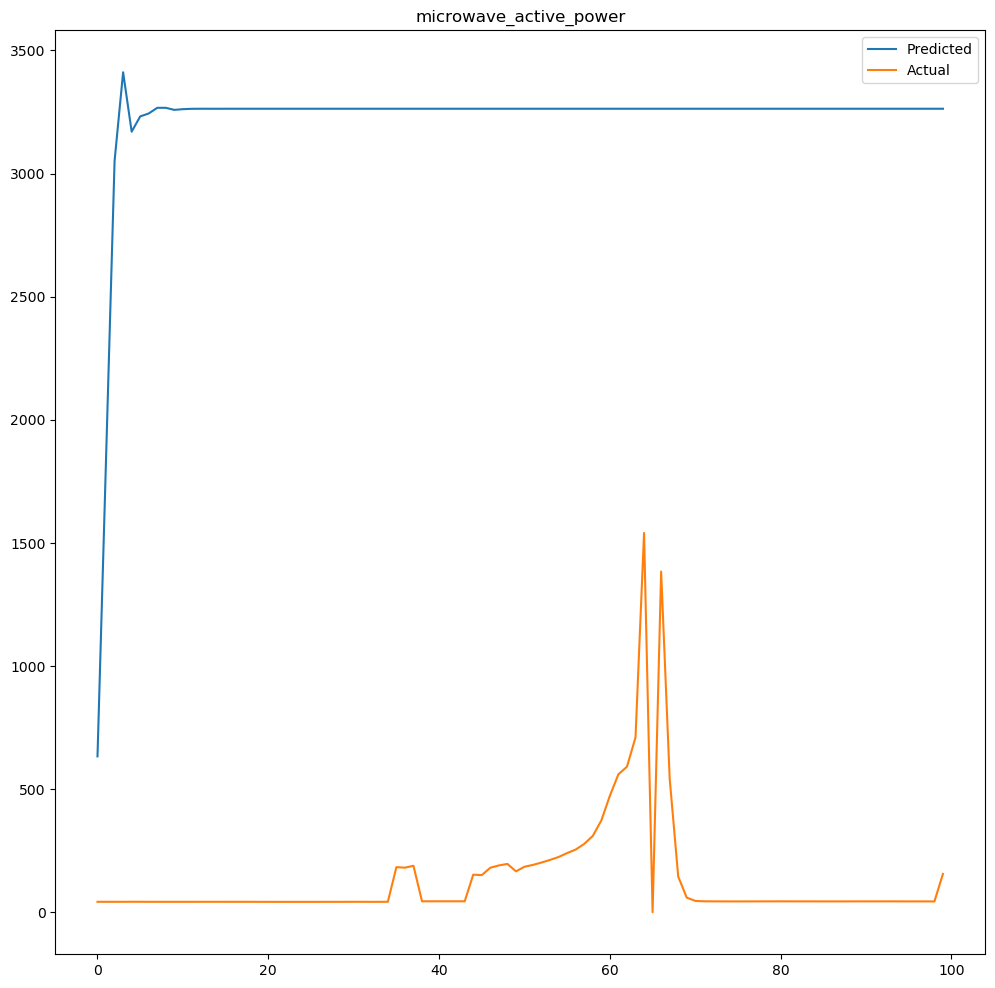

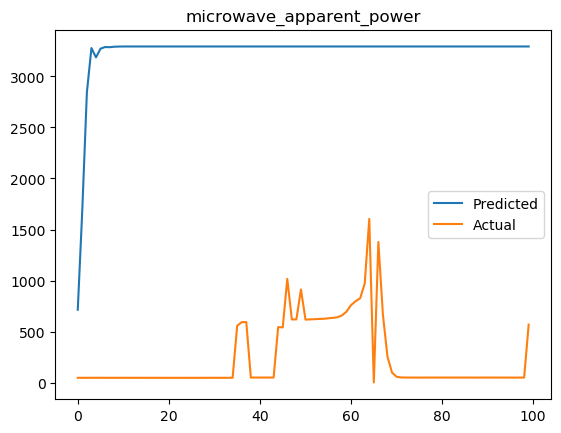

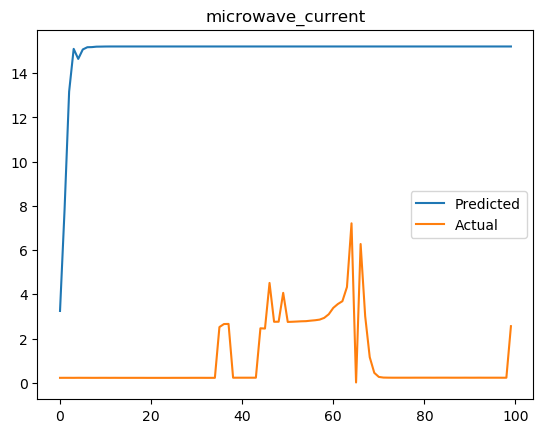

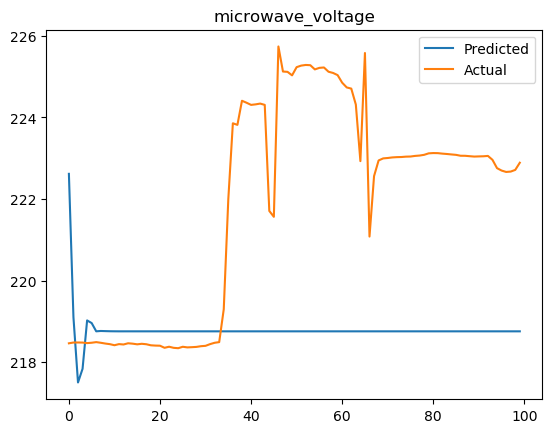

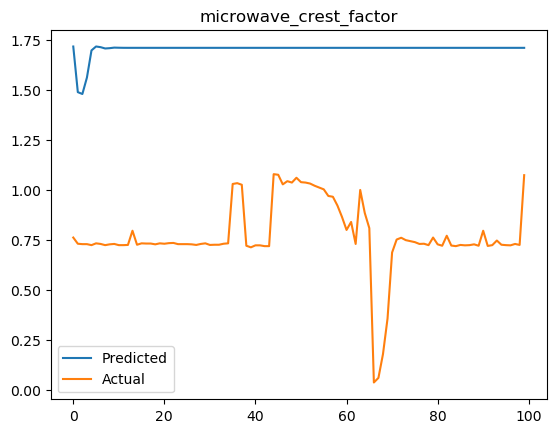

In [81]:
microwave_test = microwave_test.iloc[:, -5:]

plt.figure(figsize=(12,12))
i = 0
for feature in microwave_test.columns:
    plt.plot(true_predictions_microwave.index, true_predictions_microwave[true_predictions_microwave.columns[i]], label='Predicted')
    plt.plot(microwave_test.index, microwave_test[microwave_test.columns[i]], label='Actual')
    plt.title(microwave_test.columns[i])
    plt.legend()
    plt.show()
    i = i + 1

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
    # Convert target columns to a numpy array
aggregated_features = ['aggregated_active_power', 'aggregated_apparent_power', 'aggregated_current', 'aggregated_voltage', 'aggregated_crest_factor']
fridge_features = ['fridge_active_power', 'fridge_apparent_power','fridge_current', 'fridge_voltage', 'fridge_crest_factor']
washing_machine_features = ['washing_machine_active_power', 'washing_machine_apparent_power', 'washing_machine_current','washing_machine_voltage','washing_machine_crest_factor']
microwave_features = ['microwave_active_power', 'microwave_apparent_power', 'microwave_current','microwave_voltage','microwave_crest_factor']
length = 60
batch_size = 1
# now since on normal circumstances one sample per minute is taken, let us try to predict using each time 60 prior
# values for a whole hour. We cannot do this for a day since we have a small sample<<1440 (minutes in a day)
# the thing is though that these timestamps are scattered , meaning they are not in sequence , e.g. one could be taken 
# in a Sunday evening and the next one on a week day in the morning
# This is why we don't expect Rnn's here to be the best option as well as in enertalk datasets when we use these joined datasets

train_generator_fridge = TimeseriesGenerator(fridge_scaled_train[:, :5], fridge_scaled_train[:, -5:], length=length, batch_size=batch_size)
validation_generator_fridge = TimeseriesGenerator(fridge_scaled_test[:, :5], fridge_scaled_test[:, -5:], length=length, batch_size=batch_size)


# Build the RNN model
model_fridge = Sequential()
model_fridge.add(LSTM(256, activation='relu', input_shape=(length, len(aggregated_features)), return_sequences=True))
model_fridge.add(LSTM(128, return_sequences=True))
model_fridge.add(Dropout(0.25))
model_fridge.add(LSTM(64, return_sequences=True))
model_fridge.add(Dropout(0.25))
model_fridge.add(LSTM(32, return_sequences=True))
model_fridge.add(Dropout(0.25))
model_fridge.add(LSTM(16))
model_fridge.add(Dropout(0.25))
model_fridge.add(Dense(len(fridge_features)))

model_fridge.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'accuracy'])
model_fridge.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history_fridge = model_fridge.fit(train_generator_fridge, epochs=10, validation_data=validation_generator_fridge, callbacks=[early_stop])

Metal device set to: Apple M1


2023-06-08 21:25:22.526198: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-08 21:25:22.526877: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 256)           268288    
                                                                 
 lstm_1 (LSTM)               (None, 60, 128)           197120    
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 60, 32)            12416     
                                                                 
 dropout_2 (Dropout)         (None, 60, 32)            0

2023-06-08 21:25:23.327903: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-08 21:25:25.121410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 21:25:25.991557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 21:25:26.340056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 21:25:26.537064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 21:25:26.679420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 21:25:27.075657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114

559/559 [==============================] - ETA: 0s - loss: 0.0512 - mse: 0.0512 - mae: 0.1679 - accuracy: 0.7138

2023-06-08 21:55:12.359334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 21:55:12.685224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 21:55:12.806835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 21:55:12.925504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 21:55:13.042685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


559/559 [==============================] - 1799s 3s/step - loss: 0.0512 - mse: 0.0512 - mae: 0.1679 - accuracy: 0.7138 - val_loss: 0.0662 - val_mse: 0.0662 - val_mae: 0.1957 - val_accuracy: 0.8163
Epoch 2/10
559/559 [==============================] - 1646s 3s/step - loss: 0.0483 - mse: 0.0483 - mae: 0.1609 - accuracy: 0.7263 - val_loss: 0.0600 - val_mse: 0.0600 - val_mae: 0.1783 - val_accuracy: 0.8163
Epoch 3/10
559/559 [==============================] - 1655s 3s/step - loss: 0.0449 - mse: 0.0449 - mae: 0.1515 - accuracy: 0.7227 - val_loss: 0.0571 - val_mse: 0.0571 - val_mae: 0.1722 - val_accuracy: 0.8163
Epoch 4/10
559/559 [==============================] - 1662s 3s/step - loss: 0.0410 - mse: 0.0410 - mae: 0.1424 - accuracy: 0.7513 - val_loss: 0.0591 - val_mse: 0.0591 - val_mae: 0.1849 - val_accuracy: 0.8163
Epoch 5/10
559/559 [==============================] - 1695s 3s/step - loss: 0.0367 - mse: 0.0367 - mae: 0.1296 - accuracy: 0.7782 - val_loss: 0.0639 - val_mse: 0.0639 - val_mae: 0

In [6]:
n_features_f = len(aggregated_features)  # Number of aggregated features

test_predictions_f = []


first_eval_batch_f = fridge_scaled_train[-length:, :5]   # Select the aggregated features
# to be exact the last 5 from the scaled (from the columns we use to predict , the aggregated oned
# which are the first five cols) and then from these cols we get the last 5 because we set the 
#  length to be 5 and these will be used to predict the first values we want one point in to the future
# hence the last 5 are used to predict the first and then we loop
# to go through all our test dataset 109 lines

first_eval_batch_f = first_eval_batch_f.reshape((1, length, n_features_f))

current_batch_f = first_eval_batch_f

for i in range(len(fridge_test)):        #
    # Get prediction 1 time step ahead ([0] is for grabbing just the number instead of [array])
    current_pred_f = model_fridge.predict(current_batch_f)[0]

    # Inverse transform the predicted values

    # Store the actual prediction
    test_predictions_f.append(current_pred_f)

    # Update the batch to include the prediction and drop the first value
    current_batch_f = np.append(current_batch_f[:, 1:, :], [[current_pred_f]], axis=1)

2023-06-09 02:08:38.259937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 02:08:38.596718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 02:08:38.772060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 02:08:38.889418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 02:08:39.003921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 215ms/step


In [8]:
test_predictions_f = pd.DataFrame(test_predictions_f)
test_predictions_f.columns = ['predicted_fridge_active_power','predicted_fridge_apparent_power','predicted_fridge_current', 'predicted_fridge_voltage', 'predicted_fridge_crest_factor']
print(test_predictions_f.info())
# since we transformed all the 10 collumns (with minmaxscaler), but we used 5 of them to predict 5
# 5 aggregated used to predict the 5 fridges data, we cannot inverse transform.
# however now we will create a dataframe with 109 entries and 5 columns(because the predictions
# of the actual test values dimensions are 109 * 5 ) this dataset will be filled with zeros,
# since the columns that have 0 will have across all their entries the same values
# after the inverse transform and then we will remove those columns 

filler_df = pd.DataFrame(0, index=range(len(fridge_test)), columns=range(5))
preds_f = pd.concat([test_predictions_f, filler_df], axis=1)
preds_f

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   predicted_fridge_active_power    109 non-null    float32
 1   predicted_fridge_apparent_power  109 non-null    float32
 2   predicted_fridge_current         109 non-null    float32
 3   predicted_fridge_voltage         109 non-null    float32
 4   predicted_fridge_crest_factor    109 non-null    float32
dtypes: float32(5)
memory usage: 2.3 KB
None


,predicted_fridge_active_power,predicted_fridge_apparent_power,predicted_fridge_current,predicted_fridge_voltage,predicted_fridge_crest_factor,0,1,2,3,4
0,0.120152,0.175225,0.046731,0.356342,0.254972,0,0,0,0,0
1,0.145785,0.202999,0.082523,0.311300,0.247475,0,0,0,0,0
2,0.180608,0.240096,0.125478,0.253574,0.238240,0,0,0,0,0
3,0.215923,0.277985,0.163082,0.194093,0.226311,0,0,0,0,0
4,0.250289,0.312249,0.194172,0.138953,0.211865,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
104,0.120855,0.177541,0.076840,0.180448,0.177087,0,0,0,0,0
105,0.134173,0.198117,0.087316,0.156280,0.163270,0,0,0,0,0
106,0.149716,0.220369,0.102533,0.132664,0.152063,0,0,0,0,0
107,0.169016,0.245755,0.124038,0.110543,0.144204,0,0,0,0,0


In [9]:

inverse_transformed_data = scaler3.inverse_transform(preds_f)
true_predictions_fridge = pd.DataFrame(inverse_transformed_data)
true_predictions_fridge 

,0,1,2,3,4,5,6,7,8,9
0,478.483377,710.172592,1.081823,220.046029,2.817723,13.889,14.058,0.065,216.281,0.072
1,573.940720,812.871738,1.693651,219.557228,2.755189,13.889,14.058,0.065,216.281,0.072
2,703.623834,950.046631,2.427914,218.930785,2.678159,13.889,14.058,0.065,216.281,0.072
3,835.138423,1090.147894,3.070730,218.285294,2.578658,13.889,14.058,0.065,216.281,0.072
4,963.119359,1216.846809,3.602171,217.686920,2.458169,13.889,14.058,0.065,216.281,0.072
...,...,...,...,...,...,...,...,...,...,...
104,481.100266,718.736043,1.596495,218.137224,2.168082,13.889,14.058,0.065,216.281,0.072
105,530.697607,794.820696,1.775582,217.874956,2.052833,13.889,14.058,0.065,216.281,0.072
106,588.579263,877.101696,2.035700,217.618671,1.959359,13.889,14.058,0.065,216.281,0.072
107,660.452362,970.972304,2.403308,217.378613,1.893807,13.889,14.058,0.065,216.281,0.072


In [13]:
# we see that columns 5,6,7,8 and 9 contain the equal values across all the entries, so
# we drop them
true_predictions_fridge = true_predictions_fridge.iloc[:, :5]
true_predictions_fridge.columns = ['predicted_fridge_active_power','predicted_fridge_apparent_power','predicted_fridge_current', 'predicted_fridge_voltage', 'predicted_fridge_crest_factor']
true_predictions_fridge
fridge_test = fridge_test.iloc[:, -5:]

In [14]:
fridge_test

,fridge_active_power,fridge_apparent_power,fridge_current,fridge_voltage,fridge_crest_factor
0,346.769,360.155,1.616,223.831,0.618
1,254.184,292.649,1.311,223.853,0.733
2,213.357,265.950,1.190,223.924,0.757
3,193.341,252.659,1.130,223.995,0.783
4,182.632,244.398,1.093,224.012,0.785
...,...,...,...,...,...
104,14.923,15.017,0.068,220.632,0.714
105,14.785,14.858,0.067,220.655,0.704
106,14.699,14.799,0.067,220.684,0.714
107,14.738,14.872,0.068,220.717,0.711


In [15]:
true_predictions_fridge

,predicted_fridge_active_power,predicted_fridge_apparent_power,predicted_fridge_current,predicted_fridge_voltage,predicted_fridge_crest_factor
0,478.483377,710.172592,1.081823,220.046029,2.817723
1,573.940720,812.871738,1.693651,219.557228,2.755189
2,703.623834,950.046631,2.427914,218.930785,2.678159
3,835.138423,1090.147894,3.070730,218.285294,2.578658
4,963.119359,1216.846809,3.602171,217.686920,2.458169
...,...,...,...,...,...
104,481.100266,718.736043,1.596495,218.137224,2.168082
105,530.697607,794.820696,1.775582,217.874956,2.052833
106,588.579263,877.101696,2.035700,217.618671,1.959359
107,660.452362,970.972304,2.403308,217.378613,1.893807


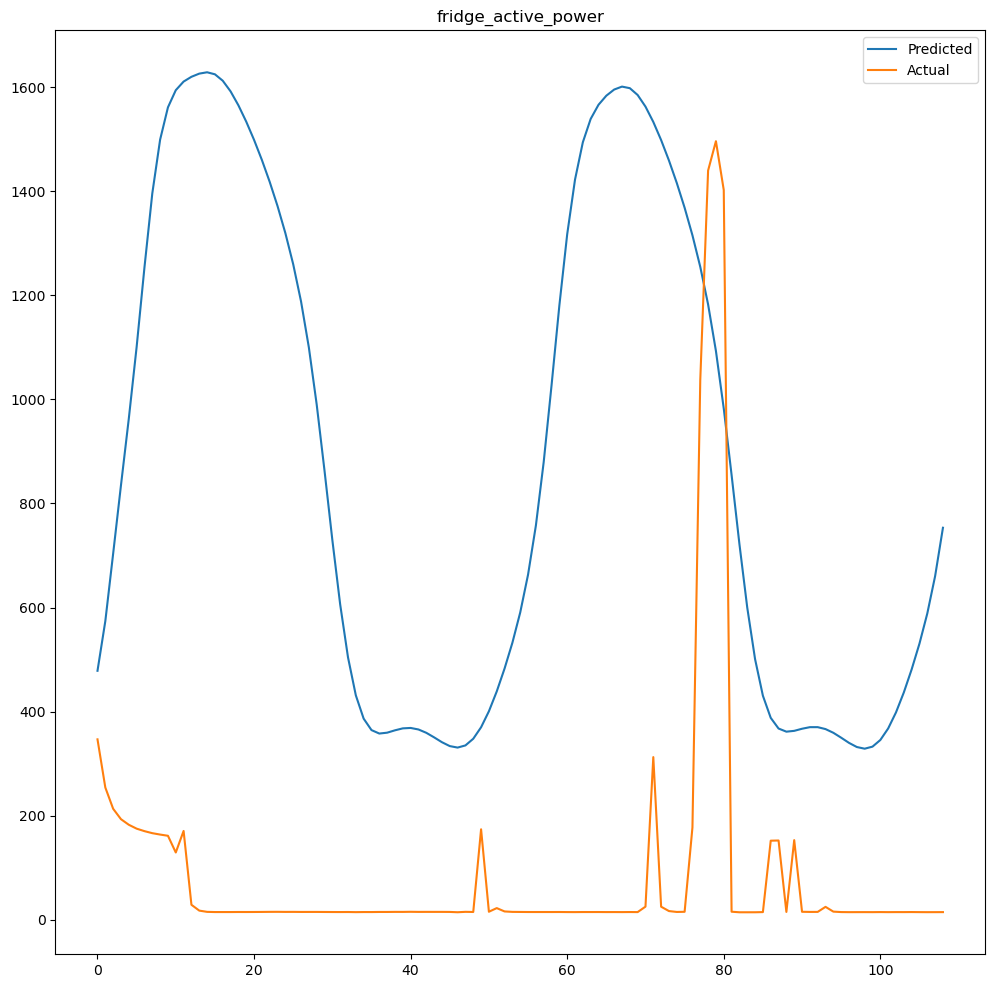

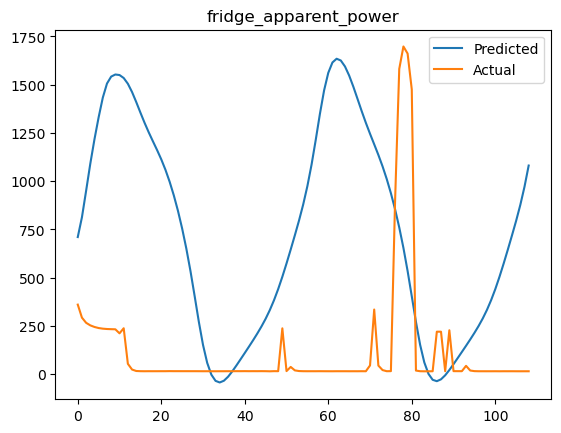

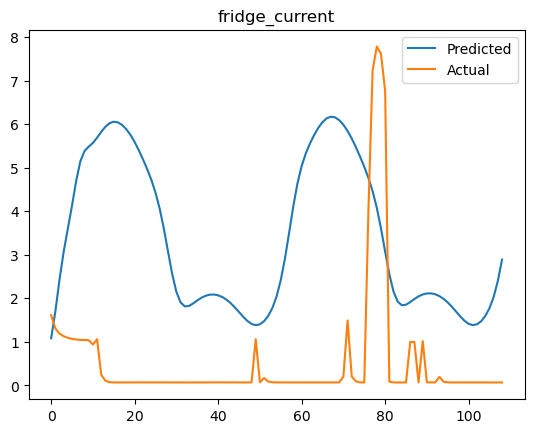

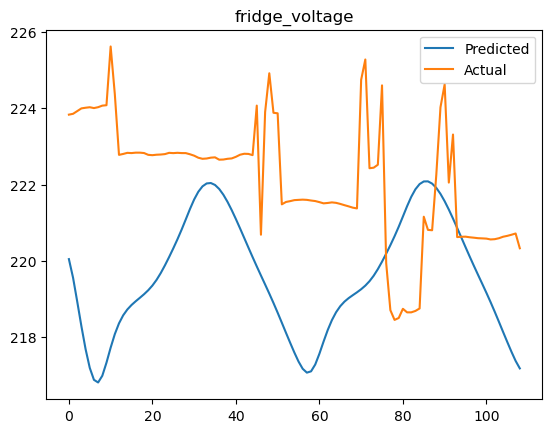

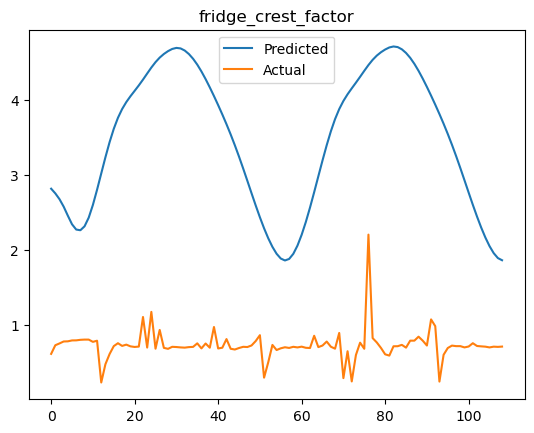

In [16]:
plt.figure(figsize=(12,12))
i = 0
for feature in fridge_test.columns:
    plt.plot(true_predictions_fridge.index, true_predictions_fridge[true_predictions_fridge.columns[i]], label='Predicted')
    plt.plot(fridge_test.index, fridge_test[fridge_test.columns[i]], label='Actual')
    plt.title(fridge_test.columns[i])
    plt.legend()
    plt.show()
    i = i+1

In [17]:
metrics_fridge = pd.DataFrame(history_fridge.history)
metrics_fridge
losses_fridge = metrics_fridge[['loss','val_loss']]
mae_fridge = metrics_fridge[['mae','val_mae']]
accuracy_fridge = metrics_fridge[['accuracy' , 'val_accuracy']]

<AxesSubplot: >

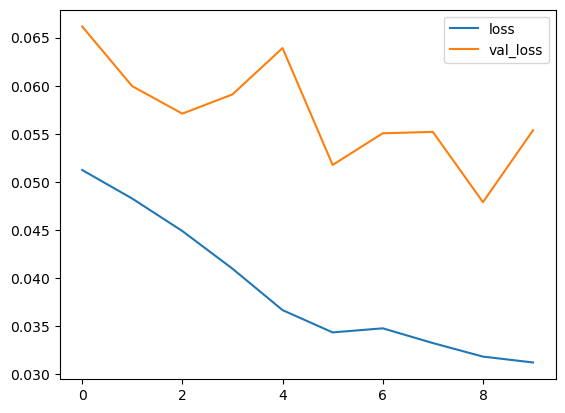

In [18]:
losses_fridge.plot()

<AxesSubplot: >

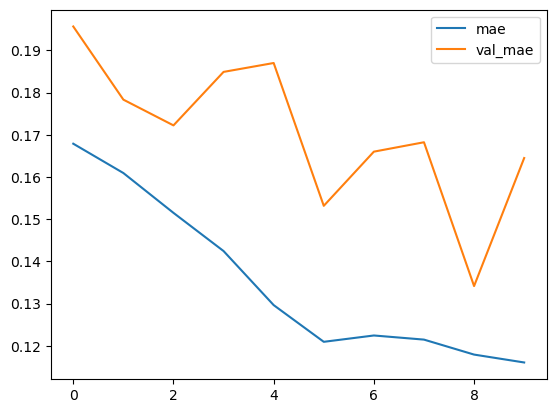

In [19]:
mae_fridge.plot()

<AxesSubplot: >

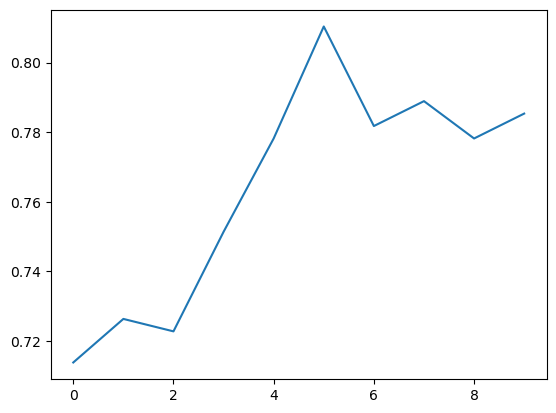

In [20]:
accuracy_fridge['accuracy'].plot()

In [22]:
# we will implement one more rnn for the fridge set but we are going to se the length equal to 20 and reduce the epochs to 4 ,
# since on both models there is not much to improve afterwards.
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
    # Convert target columns to a numpy array
aggregated_features = ['aggregated_active_power', 'aggregated_apparent_power', 'aggregated_current', 'aggregated_voltage', 'aggregated_crest_factor']
fridge_features = ['fridge_active_power', 'fridge_apparent_power','fridge_current', 'fridge_voltage', 'fridge_crest_factor']
washing_machine_features = ['washing_machine_active_power', 'washing_machine_apparent_power', 'washing_machine_current','washing_machine_voltage','washing_machine_crest_factor']
microwave_features = ['microwave_active_power', 'microwave_apparent_power', 'microwave_current','microwave_voltage','microwave_crest_factor']
length = 20
batch_size = 1
# now since on normal circumstances one sample per minute is taken, let us try to predict using each time 60 prior
# values for a whole hour. We cannot do this for a day since we have a small sample<<1440 (minutes in a day)
# the thing is though that these timestamps are scattered , meaning they are not in sequence , e.g. one could be taken 
# in a Sunday evening and the next one on a week day in the morning
# This is why we don't expect Rnn's here to be the best option as well as in enertalk datasets when we use these joined datasets

train_generator_fridge = TimeseriesGenerator(fridge_scaled_train[:, :5], fridge_scaled_train[:, -5:], length=length, batch_size=batch_size)
validation_generator_fridge = TimeseriesGenerator(fridge_scaled_test[:, :5], fridge_scaled_test[:, -5:], length=length, batch_size=batch_size)


# Build the RNN model
model_fridge = Sequential()
model_fridge.add(LSTM(256, activation='relu', input_shape=(length, len(aggregated_features)), return_sequences=True))
model_fridge.add(LSTM(128, return_sequences=True))
model_fridge.add(Dropout(0.25))
model_fridge.add(LSTM(64, return_sequences=True))
model_fridge.add(Dropout(0.25))
model_fridge.add(LSTM(32, return_sequences=True))
model_fridge.add(Dropout(0.25))
model_fridge.add(LSTM(16))
model_fridge.add(Dropout(0.25))
model_fridge.add(Dense(len(fridge_features)))

model_fridge.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'accuracy'])
model_fridge.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Train the model
history_fridge = model_fridge.fit(train_generator_fridge, epochs=4, validation_data=validation_generator_fridge, callbacks=[early_stop])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 20, 256)           268288    
                                                                 
 lstm_11 (LSTM)              (None, 20, 128)           197120    
                                                                 
 dropout_8 (Dropout)         (None, 20, 128)           0         
                                                                 
 lstm_12 (LSTM)              (None, 20, 64)            49408     
                                                                 
 dropout_9 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_13 (LSTM)              (None, 20, 32)            12416     
                                                                 
 dropout_10 (Dropout)        (None, 20, 32)           

2023-06-09 02:20:35.741005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 02:20:36.230160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 02:20:36.324860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 02:20:36.420937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 02:20:36.523931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 02:20:36.680984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 02:20:36.839278: I tensorflow/core/grappler/optimizers/cust

599/599 [==============================] - ETA: 0s - loss: 0.0518 - mse: 0.0518 - mae: 0.1722 - accuracy: 0.7062

2023-06-09 02:24:49.515033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 02:24:49.684449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 02:24:49.761492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 02:24:49.834790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 02:24:49.906785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


599/599 [==============================] - 260s 429ms/step - loss: 0.0518 - mse: 0.0518 - mae: 0.1722 - accuracy: 0.7062 - val_loss: 0.0521 - val_mse: 0.0521 - val_mae: 0.1915 - val_accuracy: 0.8989
Epoch 2/4
599/599 [==============================] - 249s 415ms/step - loss: 0.0483 - mse: 0.0483 - mae: 0.1624 - accuracy: 0.7262 - val_loss: 0.0502 - val_mse: 0.0502 - val_mae: 0.1787 - val_accuracy: 0.8989
Epoch 3/4
599/599 [==============================] - 261s 436ms/step - loss: 0.0441 - mse: 0.0441 - mae: 0.1507 - accuracy: 0.7379 - val_loss: 0.0560 - val_mse: 0.0560 - val_mae: 0.2046 - val_accuracy: 0.8989
Epoch 4/4
599/599 [==============================] - 267s 446ms/step - loss: 0.0419 - mse: 0.0419 - mae: 0.1446 - accuracy: 0.7479 - val_loss: 0.0378 - val_mse: 0.0378 - val_mae: 0.1459 - val_accuracy: 0.8989


In [23]:
n_features_f = len(aggregated_features)  # Number of aggregated features

test_predictions_f = []


first_eval_batch_f = fridge_scaled_train[-length:, :5]   # Select the aggregated features
# to be exact the last 5 from the scaled (from the columns we use to predict , the aggregated oned
# which are the first five cols) and then from these cols we get the last 5 because we set the 
#  length to be 5 and these will be used to predict the first values we want one point in to the future
# hence the last 5 are used to predict the first and then we loop
# to go through all our test dataset 109 lines

first_eval_batch_f = first_eval_batch_f.reshape((1, length, n_features_f))

current_batch_f = first_eval_batch_f

for i in range(len(fridge_test)):        #
    # Get prediction 1 time step ahead ([0] is for grabbing just the number instead of [array])
    current_pred_f = model_fridge.predict(current_batch_f)[0]

    # Inverse transform the predicted values

    # Store the actual prediction
    test_predictions_f.append(current_pred_f)

    # Update the batch to include the prediction and drop the first value
    current_batch_f = np.append(current_batch_f[:, 1:, :], [[current_pred_f]], axis=1)

2023-06-09 02:41:32.863401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 02:41:33.081439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 02:41:33.151194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 02:41:33.213372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-09 02:41:33.281635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 52ms/step


In [24]:
test_predictions_f = pd.DataFrame(test_predictions_f)
test_predictions_f.columns = ['predicted_fridge_active_power','predicted_fridge_apparent_power','predicted_fridge_current', 'predicted_fridge_voltage', 'predicted_fridge_crest_factor']
print(test_predictions_f.info())
# since we transformed all the 10 collumns (with minmaxscaler), but we used 5 of them to predict 5
# 5 aggregated used to predict the 5 fridges data, we cannot inverse transform.
# however now we will create a dataframe with 109 entries and 5 columns(because the predictions
# of the actual test values dimensions are 109 * 5 ) this dataset will be filled with zeros,
# since the columns that have 0 will have across all their entries the same values
# after the inverse transform and then we will remove those columns 

filler_df = pd.DataFrame(0, index=range(len(fridge_test)), columns=range(5))
preds_f = pd.concat([test_predictions_f, filler_df], axis=1)
preds_f

inverse_transformed_data = scaler3.inverse_transform(preds_f)
true_predictions_fridge = pd.DataFrame(inverse_transformed_data)
true_predictions_fridge 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   predicted_fridge_active_power    109 non-null    float32
 1   predicted_fridge_apparent_power  109 non-null    float32
 2   predicted_fridge_current         109 non-null    float32
 3   predicted_fridge_voltage         109 non-null    float32
 4   predicted_fridge_crest_factor    109 non-null    float32
dtypes: float32(5)
memory usage: 2.3 KB
None


,0,1,2,3,4,5,6,7,8,9
0,500.032765,619.433823,0.697560,220.278412,2.650776,13.889,14.058,0.065,216.281,0.072
1,513.875267,622.561641,0.773494,220.234681,2.644057,13.889,14.058,0.065,216.281,0.072
2,544.226021,629.934927,0.961810,220.151511,2.627236,13.889,14.058,0.065,216.281,0.072
3,596.399271,644.705745,1.304670,220.037073,2.594798,13.889,14.058,0.065,216.281,0.072
4,672.999612,671.716132,1.802779,219.916754,2.542450,13.889,14.058,0.065,216.281,0.072
...,...,...,...,...,...,...,...,...,...,...
104,2029.926502,1424.295599,9.012600,219.609814,1.653166,13.889,14.058,0.065,216.281,0.072
105,2029.926502,1424.295599,9.012600,219.609814,1.653165,13.889,14.058,0.065,216.281,0.072
106,2029.926502,1424.295599,9.012600,219.609814,1.653165,13.889,14.058,0.065,216.281,0.072
107,2029.926502,1424.295599,9.012599,219.609814,1.653165,13.889,14.058,0.065,216.281,0.072


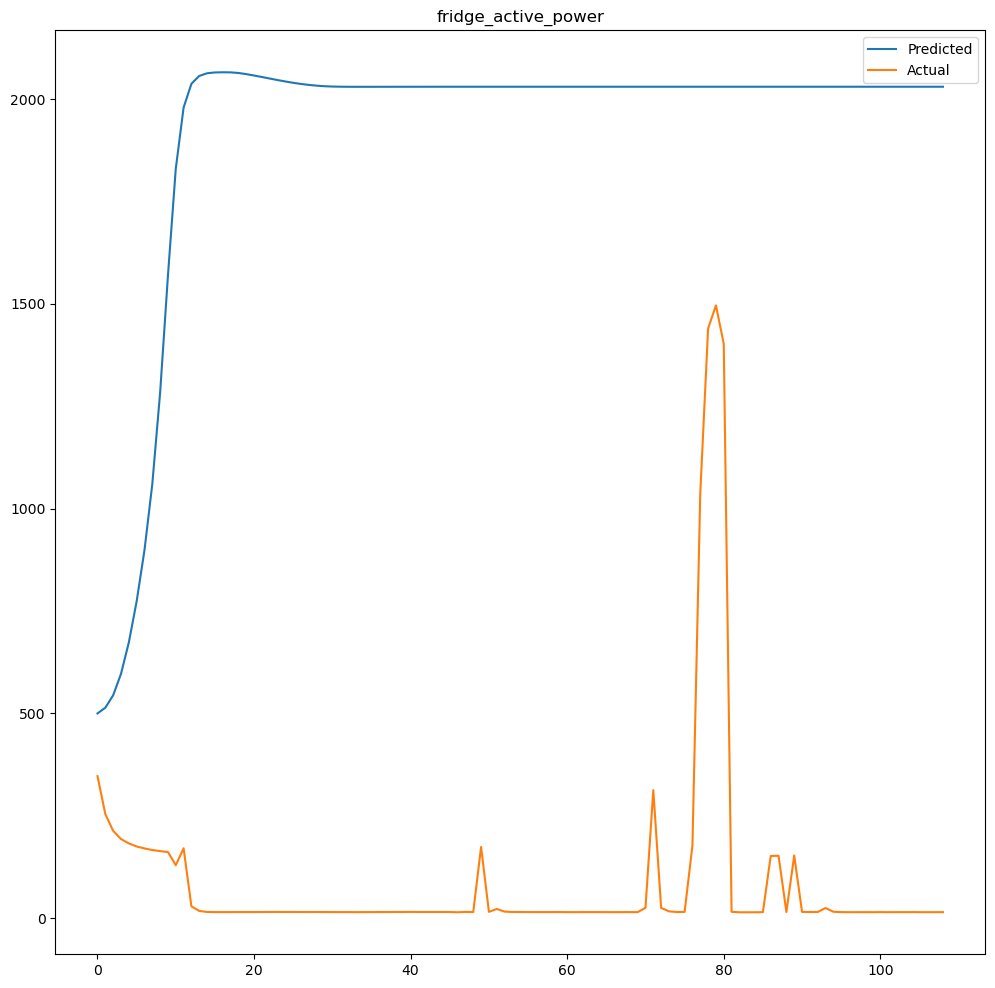

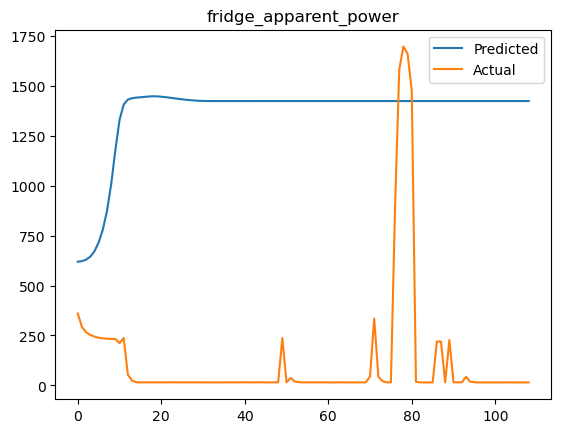

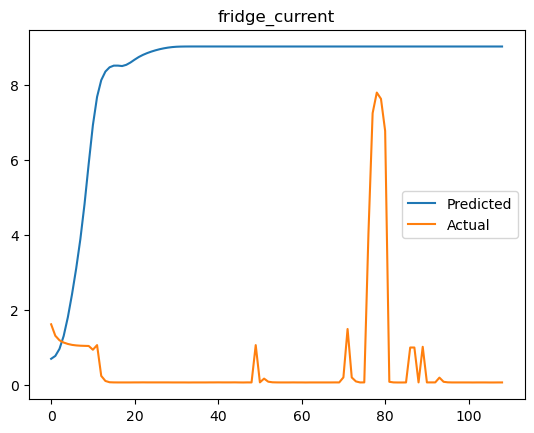

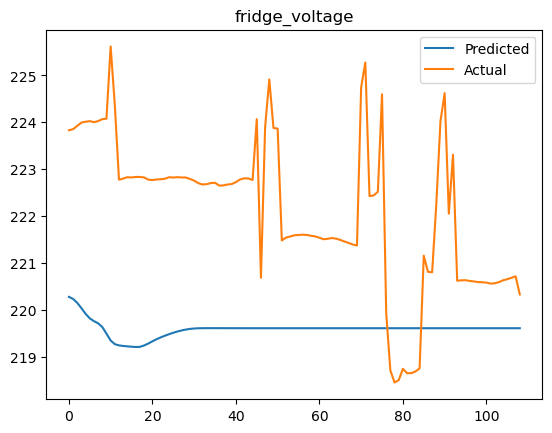

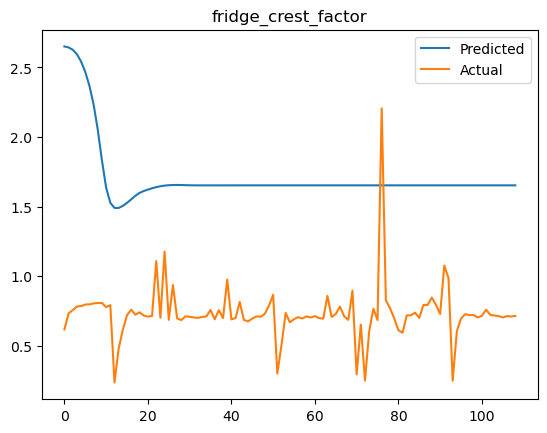

In [25]:
# we see that columns 5,6,7,8 and 9 contain the equal values across all the entries, so
# we drop them
true_predictions_fridge = true_predictions_fridge.iloc[:, :5]
true_predictions_fridge.columns = ['predicted_fridge_active_power','predicted_fridge_apparent_power','predicted_fridge_current', 'predicted_fridge_voltage', 'predicted_fridge_crest_factor']
true_predictions_fridge
fridge_test = fridge_test.iloc[:, -5:]
plt.figure(figsize=(12,12))
i = 0
for feature in fridge_test.columns:
    plt.plot(true_predictions_fridge.index, true_predictions_fridge[true_predictions_fridge.columns[i]], label='Predicted')
    plt.plot(fridge_test.index, fridge_test[fridge_test.columns[i]], label='Actual')
    plt.title(fridge_test.columns[i])
    plt.legend()
    plt.show()
    i = i+1